Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression. In this section, we will develop the intuition behind support vector machines and their use in classification problems.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# Motivating Support Vector Machine

generative vs discriminative：

区别于贝叶斯系列的生成方法( 对每个类进行了随机分布的假设，然后用生成的模型估计新数据点的标签）

SVM 是 判决分类（discriminative）： 用一条分割线 或者 一个超平面将各种类型分割开

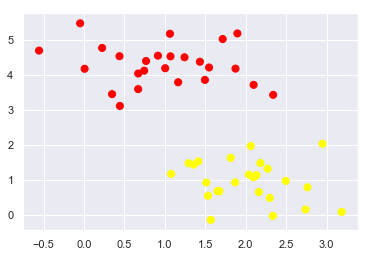

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

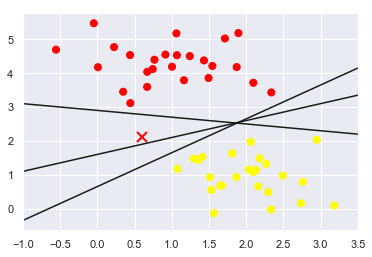

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

想要分割开两个类别， 我们可以画很多条线（其实是无限多条），但是如上图中的三条线， 不同的画法会使 点X 被分割到不同的类型

因此，画一条分割线是不够的，我们还需要别的条件来提升分类器的性能

# Support Vector Machines: Maximizing the Margin

 The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. 

(-1, 3.5)

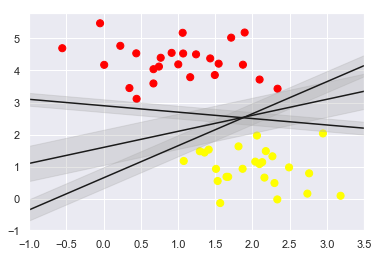

In [4]:
xfit = np.linspace(-1,3.5)
plt.scatter(X[:,0], X[:,1],c=y,s=50,cmap='autumn')

for m,b,d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m*xfit + b
    plt.plot(xfit,yfit,'-k')
    plt.fill_between(xfit,yfit-d,yfit+d,edgecolor='none',color='#AAAAAA',alpha=0.3)
plt.xlim(-1,3.5)

### Fitting a support vector machine

In [5]:
from sklearn.svm import SVC
model = SVC(kernel = 'linear',C=1E10)
model.fit(X,y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
#创建一个辅助函数帮助画出SVM的决策边界
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

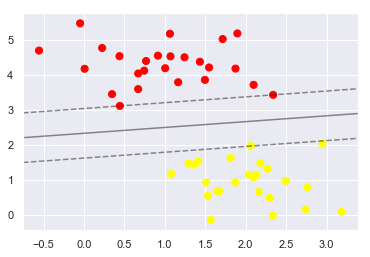

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

这就是两类数据间隔最大的分割线；

被虚线穿过的点叫做 support vector 支持向量

In [8]:
#Support vector：
model.support_vectors_

array([[ 0.44359863,  3.11530945],
       [ 2.33812285,  3.43116792],
       [ 2.06156753,  1.96918596]])

任何在正确分类一侧远离边界线的点都不会影响拟合结果；

从数学上说：是因为这些点不会对模型的损失函数造成影响

因此它们但凡没有跨越边界线，它们的位置和数量就无关紧要

示例：左图为用60个data points， 右图为120个data points，可见当左图的支持向量已经确定后， 右侧即使再添加60个点，对分割线的判决也没有任何影响

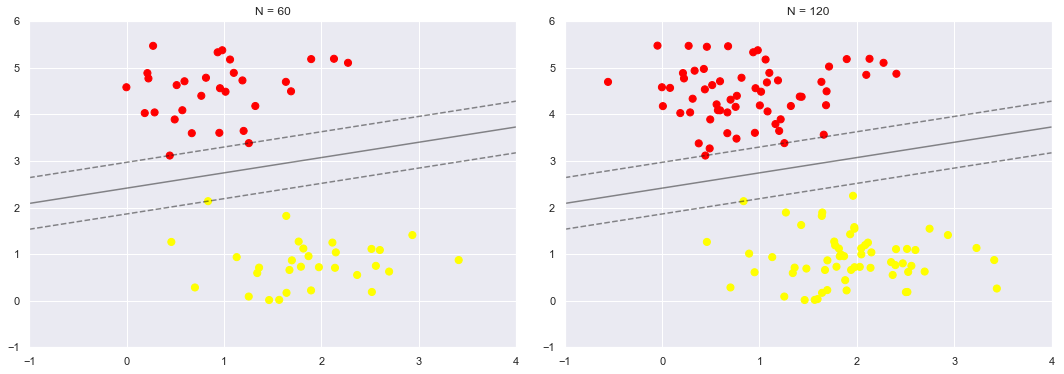

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10,50,100, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 50, 100, 200), value=10), Output()), _dom_classes…

### Beyond linear boundaries: Kernel SVM

kernel赋予了SVM解决线性不可分问题的能力，为了展示这些能力，我们先造一些线性不可分的数据：

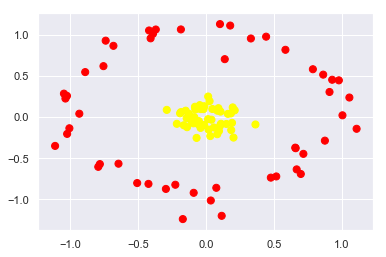

In [11]:
from sklearn.datasets.samples_generator import make_circles
X,y = make_circles(100,factor=.1,noise = .1)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='autumn')

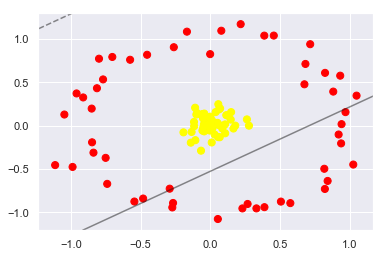

In [31]:
from sklearn.datasets.samples_generator import make_circles
X,y = make_circles(100,factor=.1,noise = .1)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='autumn')
clf = SVC(kernel='linear').fit(X,y)
plot_svc_decision_function(clf,plot_support=False)

显然，用线性的方法是没办法达成良好的分割的；

所以，we need to try some non-linear transformation

In [12]:
#let's say RBF kernel:

r = np.exp(-(X ** 2).sum(1))

In [13]:
# let's visualise what it like after the transformation:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90,45,-45], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\traitlets\traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='elev', options=(-90, 90, 45, -45), value=-90), IntSlider(value=30,…

增加了新维度后，数据肉眼可见的线性可分了

但想得到如此可分割，干净的结果，需要合理的基函数，我们需要让模型自动找出最适合的基函数。

一种策略是计算基函数在每个点上的变换结果，让SVM算法从所有结果中筛选出最优解，这就是核变换

In [15]:
clf = SVC(kernel = 'rbf', C=1E6)
clf.fit(X,y)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

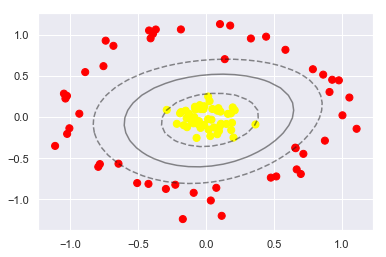

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

在虚线上的点即为支持向量， 中间的实线就是模型的决策边界

### Tuning the SVM: Softening Margins

如果有如下一组数据我们该怎么办呢？

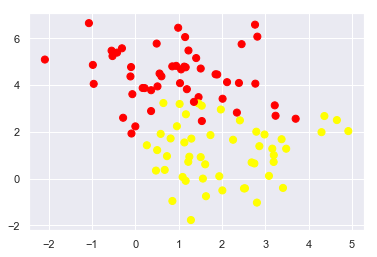

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

为了解决这个问题，SVM实现了一些修正因子来"软化"边界：  允许一些点位于边界线之内

边界线的“硬度”通过C来控制，C较大则边界很硬，C较小的话会允许一些数据点穿越边界线

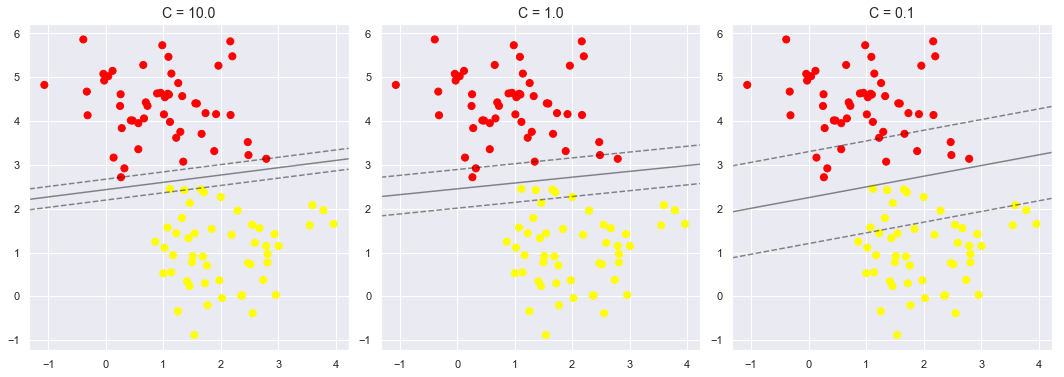

In [20]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0,1., 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

由上图可见C对边界“软硬”的调控， C的选值可以由交叉验证来寻找

# Example: Face Recognition

In [21]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


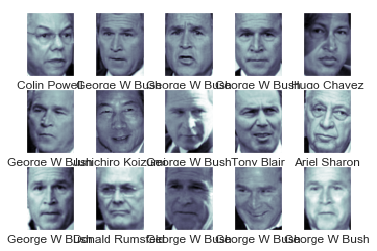

In [22]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

62 * 47 ≈ 3000 features， try PCA to reduction

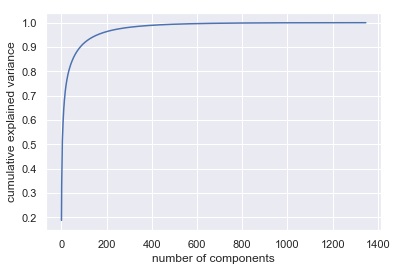

In [24]:
from sklearn.decomposition import PCA
pca = PCA().fit(faces.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

we can see that when pca(400) is almost no lose

In [62]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=200, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [64]:
from sklearn.cross_validation import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(faces.data,faces.target,random_state =42)

In [65]:
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [0.5,1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005,0.01]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is depreca

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is depreca

Wall time: 1min 44s
{'svc__C': 5, 'svc__gamma': 0.0005}


我们可见参数的选值是在输入列表的中部，如果在头尾的话，可能还需要扩大搜索的范围

In [66]:
model = grid.best_estimator_
yfit= model.predict(Xtest)

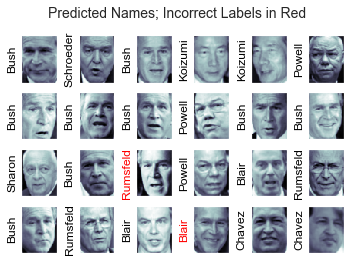

In [67]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [69]:
from sklearn.metrics import classification_report
print(classification_report(ytest,yfit,target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.93      0.78        15
     Colin Powell       0.82      0.93      0.87        68
  Donald Rumsfeld       0.75      0.77      0.76        31
    George W Bush       0.98      0.81      0.89       126
Gerhard Schroeder       0.66      0.83      0.73        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.84      0.90      0.87        42

      avg / total       0.87      0.85      0.85       337



In [72]:
from sklearn.metrics import accuracy_score
print(accuracy_score(ytest,yfit))

0.848664688427


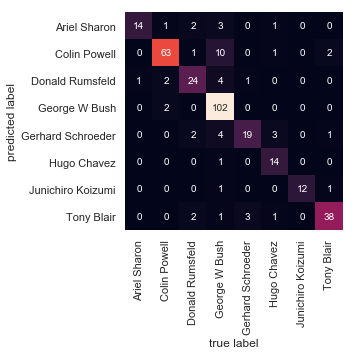

In [71]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Further:
    
    we can use OpenCV to do faces' feature engineering to get better result.

# Summary

pros：

1）消耗内存少

2）预测速度快

3）由于模型只收到边界线附近的点的影响， 因此对于高维数据的学习效果非常好

4）与合函数方法的配合具有通用性， 适用于不同类型的数据

After all： SVM is very powerful!!!!

cons：

1）复杂度： 常规 ON3， 优化之后ON2

2）训练效果非常依赖于边界软化参数C的选择，which means you have to do CV to search and it's time-consuming

3)预测结果不支持概率解释

